# 1- Physical modelling of a membrane (ie: drum)

## 1.1 Background

A drum is a 2 dimensional membrane with a wave equation that looks like so:

$$ \frac{\partial^2u}{\partial t^2} = c^2 (\frac{\partial^2u}{\partial y^2} + \frac{\partial^2u}{\partial x^2}) $$ 

Drums naturally decay so we need to add a dampnening term that shows the loss of energy in the system, thus the equation becomes:

$$\frac{\partial^2u}{\partial t^2} = c^2 (\frac{\partial^2u}{\partial y^2} + \frac{\partial^2u}{\partial x^2} - \gamma \frac{\partial u}{\partial t})$$ 

Where, $\gamma$ is the dampening coefficient and $\frac{\partial u}{\partial t}$ is the the rate of change of the waves amplitude or velocity. 


Using the defintion of finite difference for 1st and 2nd derivtives we can convert the equation into a discrete difference equation

$$\frac{d}{dt} u(t) = \frac{u(t+dt) - u(t)}{dt}$$


$$\frac{d^2}{dt^2} u(t) = \frac{u(t+dt) - 2u(t) + u(t-dt)}{dt^2}$$ 

using notation u(t,i,j) we can make it more concise

$$\frac{d^2}{dt^2} u(t) = \frac{u_{i,j}^{n+1} - 2u_{i,j}^n + u_{i,j}^{n-1}}{dt^2}$$


$$\frac{1}{c^2}\left[\frac{u_{i,j}^{n+1} - 2u_{i,j}^n + u_{i,j}^{n-1}}{dt^2}\right] = \frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^{n}}{dx^2} + \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^{n}}{dy^2} - \gamma \frac{u_{i,j}^{n+1} - u_{i,j}^{n-1}}{2dt}$$

We need to isolate for $u_{i,j}^{n+1}$, using some algebra it becomes:

$$u_{i,j}^{n+1} = \left[1 + \frac{\gamma c^2 dt}{2}\right]^{-1}\left(2u_{i,j}^n - \left[1 - \frac{\gamma c^2 dt}{2}\right]u_{i,j}^{n-1} + CFL\left[u_{i+1,j}^n + u_{i-1,j}^{n} + u_{i,j-1}^{n} + u_{i,j+1}^n + 4u_{i,j}^n\right]\right)$$


Where, CFL is $ \left(\frac{c dt}{dx}\right)^2 < 0.5$ the Courant–Friedrichs–Lewy condition 

## 1.2 Simulation in Cartesian coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib notebook

### 1.2.1 Simulation of top membrane

In [4]:
# Parameters
nx = 100
ny = nx

nu = 10
c = 1

# CFL = (c*dt/dx)^2 < 0.5
CFL_eff = 0.25


sr = 48000
dt = 1/sr

time = np.arange(0,2,dt)

audio = np.zeros(len(time))


u = np.zeros((nx, ny))
u1 = np.zeros((nx, ny))
u2 = np.zeros((nx, ny))
uStrike = np.zeros((nx,ny))


# Compute middle nodes
x_mid = int(nx/2)
y_mid = int(ny/2)

# Initial conditions
for i in range(1, nx-1):
    for j in range(1,ny-1):
        uStrike[i,j] = max(0,30-(abs(x_mid - i) + abs(y_mid - j)))/30.

        
# Zero boundary conditions
uStrike[:,0] = uStrike[:,1] - (uStrike[:,1] - uStrike[:,0])
uStrike[:,ny-1] = uStrike[:,ny-2] - (uStrike[:,ny-2] - uStrike[:,ny-1])
uStrike[0,:] = uStrike[1,:] - (uStrike[1,:] - uStrike[0,:])
uStrike[nx-1,:] = uStrike[nx-2,:] - (uStrike[nx-2,:] - uStrike[nx-1,:])

# Indexing variable
t_i = 0
for t in time:
    
    u = np.zeros((nx,ny))
    
    if (t==0): 
        u1 += uStrike
    
    #Using verctorization to compute u
    u[1:nx-2,1:ny-2] = (1. / (1 + (nu * dt / 2))) * (CFL_eff * (u1[2:nx-1, 1:ny-2] + 
                                                         u1[0:nx-3, 1:ny-2] + 
                                                         u1[1:nx-2, 2:ny-1] + 
                                                         u1[1:nx-2, 0:ny-3] - 
                                                         4 * u1[1:nx-2, 1:ny-2]) +
                                               2 * u1[1:nx-2, 1:ny-2] -
                                               (1 - (nu * dt / 2)) * u2[1:nx-2, 1:ny-2])
    u2 = u1
    u1 = u
    
    CFL_eff = min(0.49, 0.25 + ((1./16)*u[nx//2,ny//2])**2)
    
    audio[t_i] = u[nx//2,ny//2]
    t_i += 1

### 1.2.2 Simulation of shell

## 1.3 Plotting and Audio

<IPython.core.display.Javascript object>


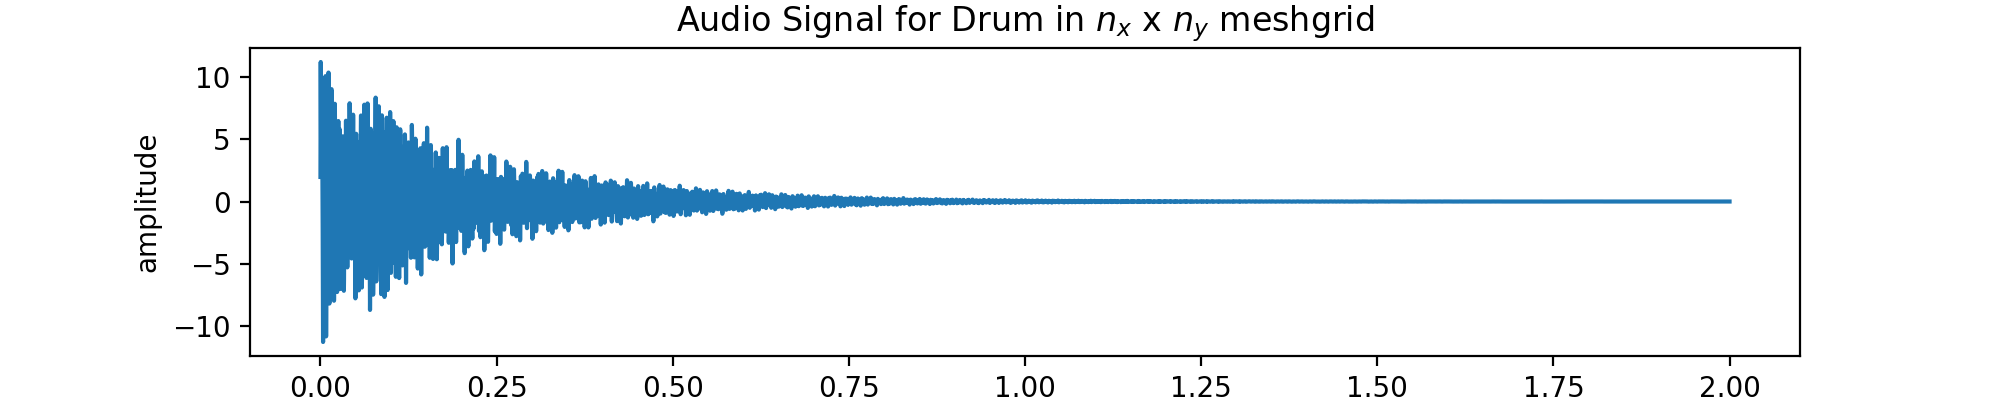

<IPython.core.display.Javascript object>


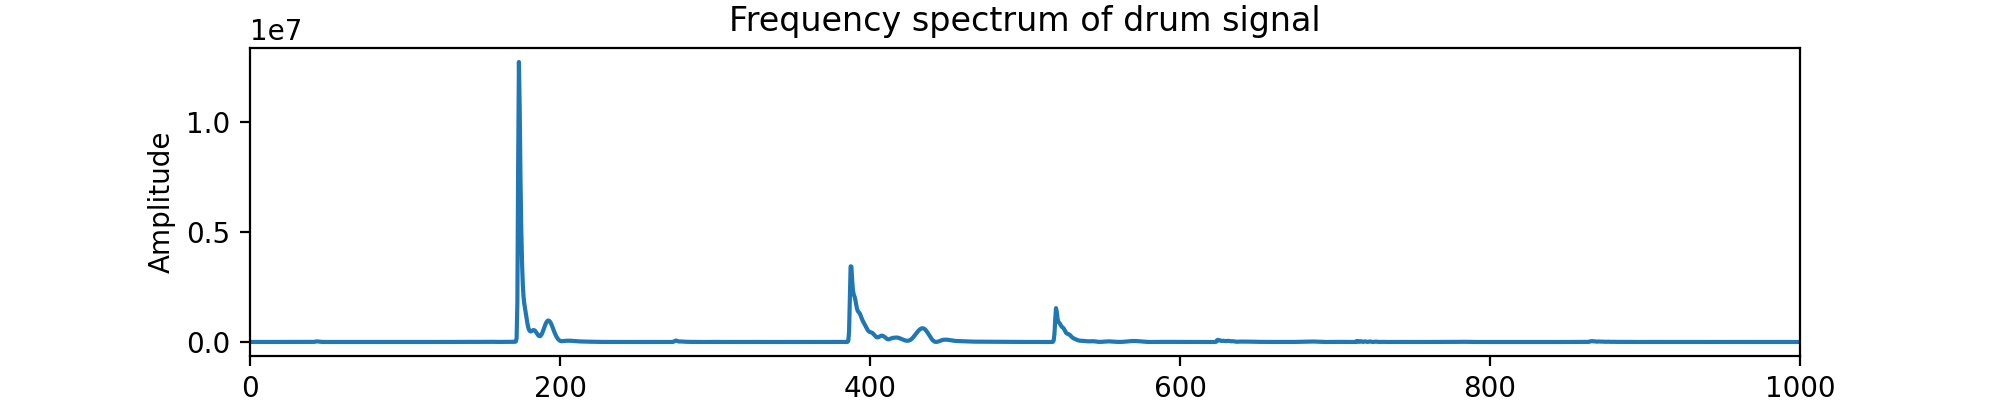

<IPython.core.display.Javascript object>


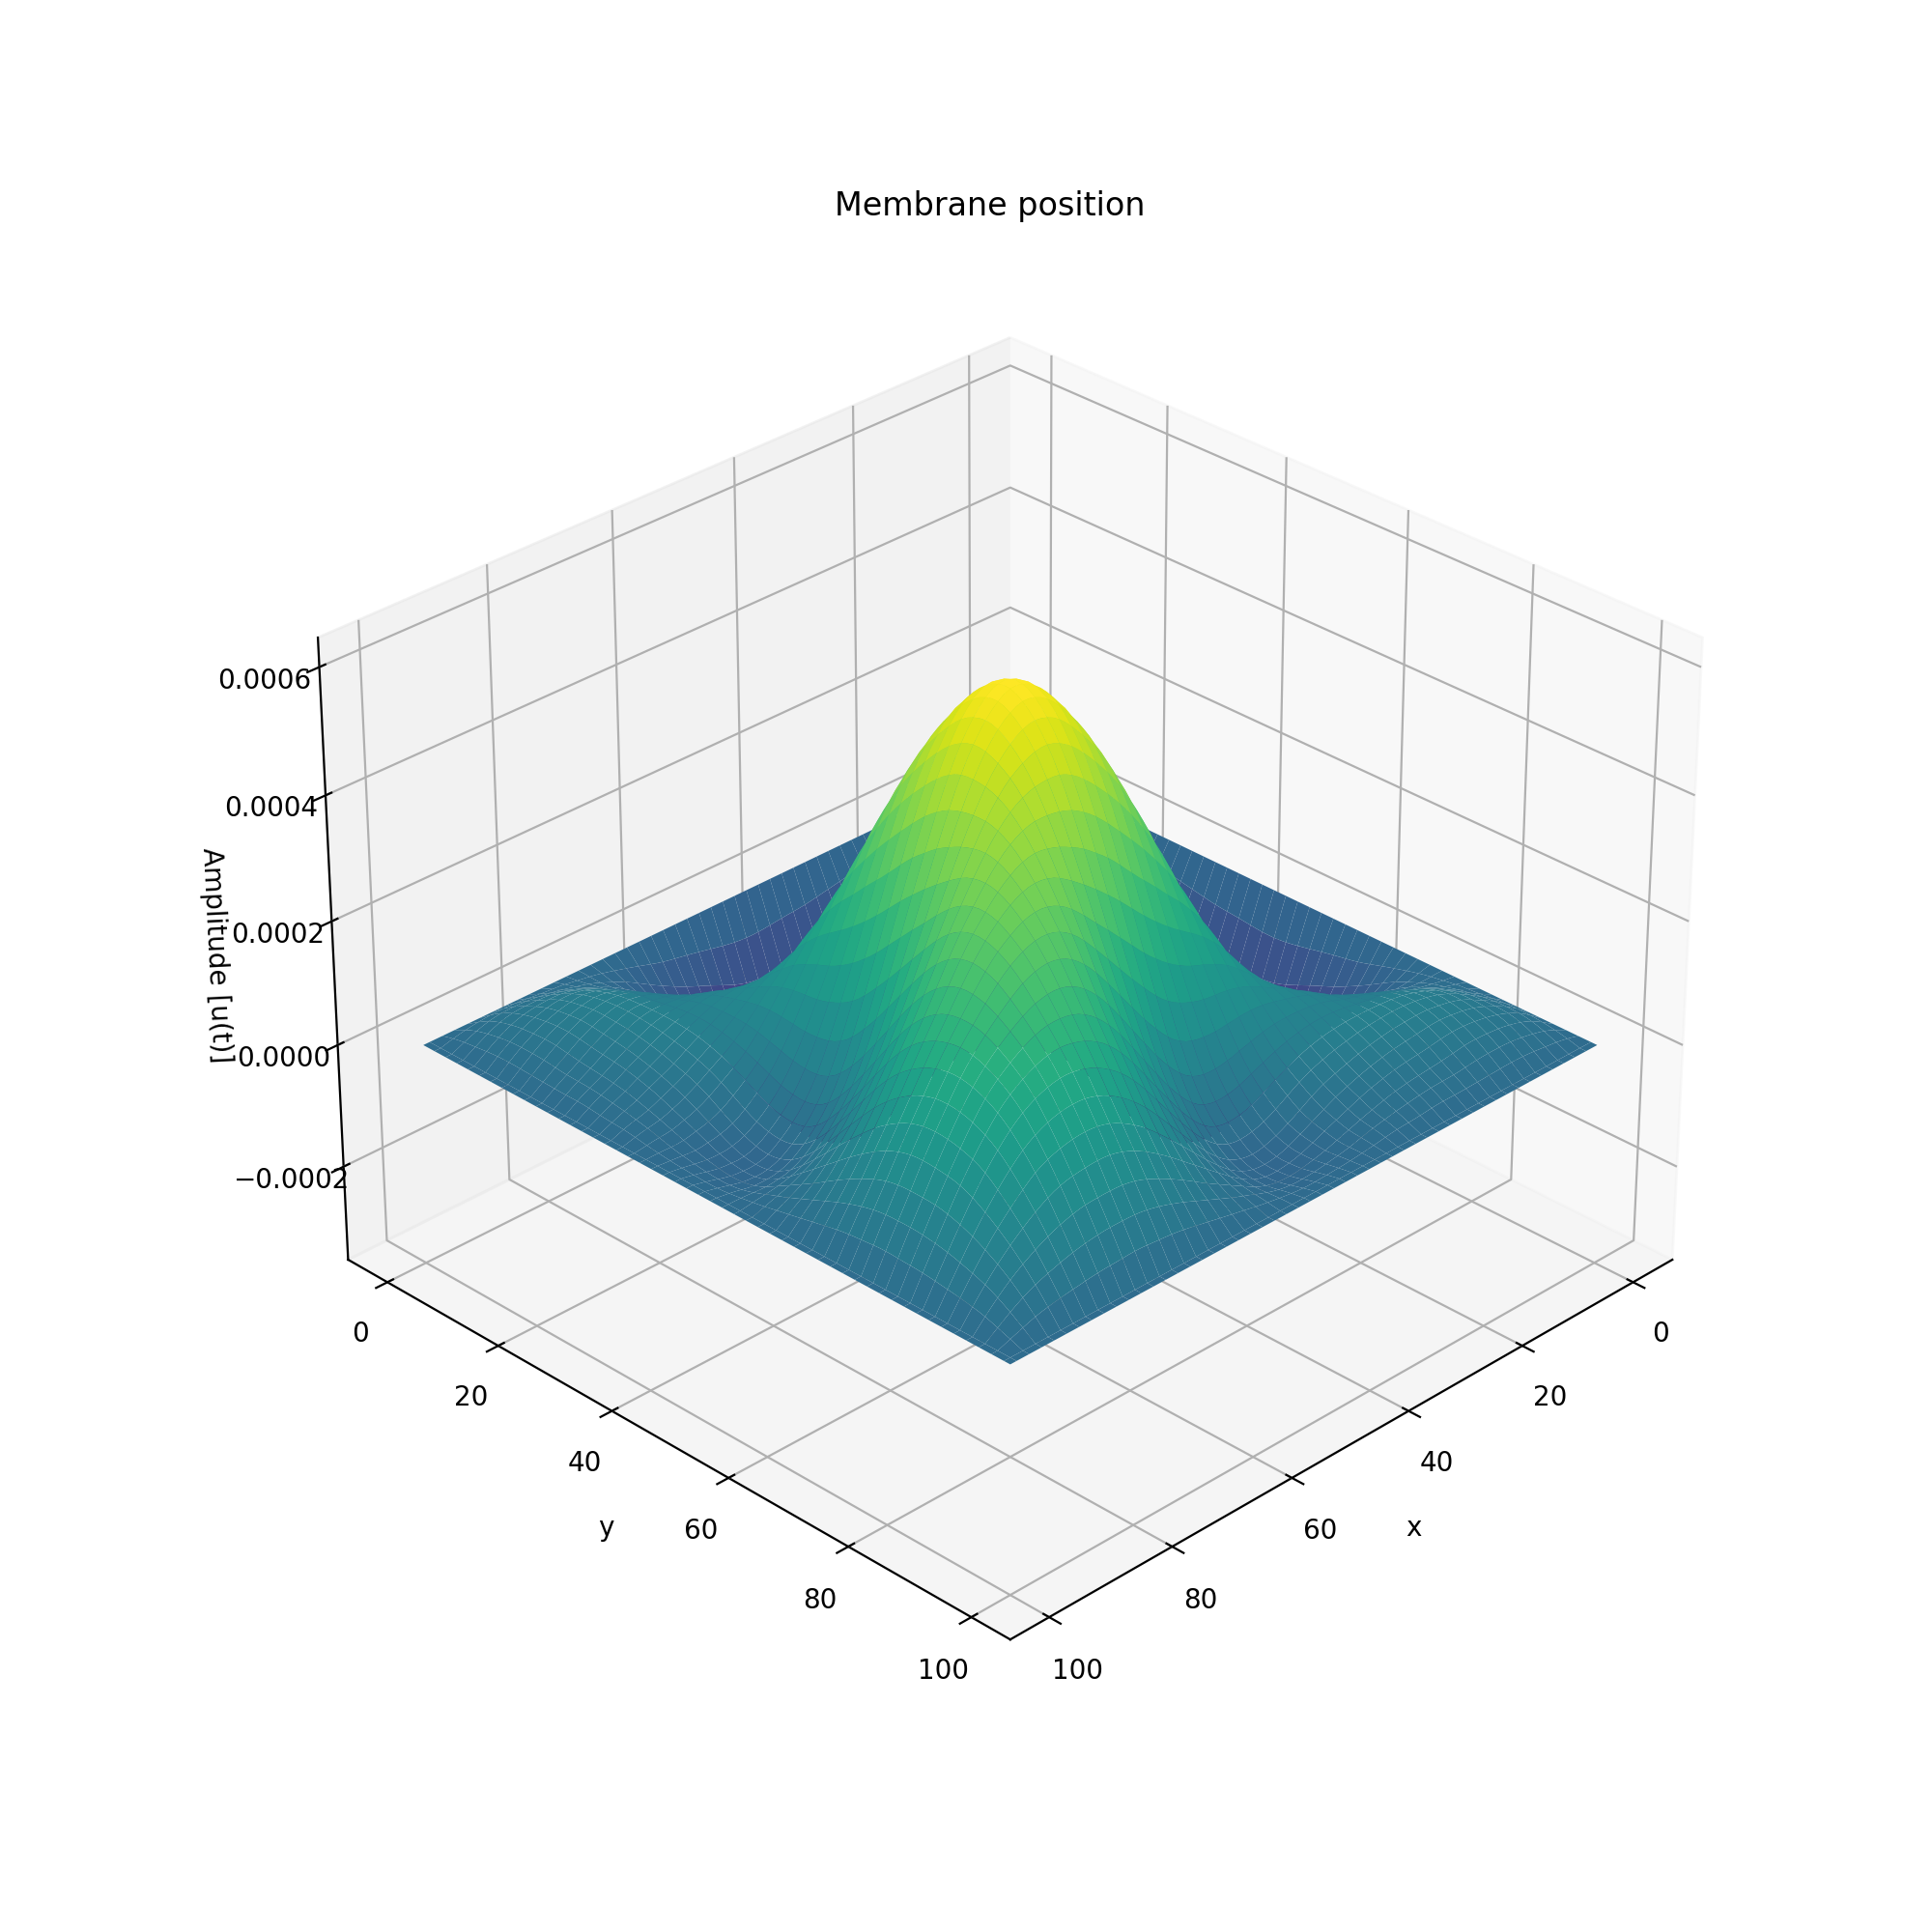

In [5]:
plt.figure(figsize=(10,2))
plt.plot(time,audio)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title(f'Audio Signal for Drum in $n_x$ x $n_y$ meshgrid')


n = len(audio)
freqs = np.fft.fftfreq(n, d=1/48000)
A = np.abs(np.fft.fft(audio*np.hamming(n)))**2
plt.figure(figsize=(10,2))
plt.plot(freqs[:n//2], A[:n//2])
plt.xlim([0,1000])
plt.xlabel('Frequency')
plt.ylabel("Amplitude")
plt.title("Frequency spectrum of drum signal")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X, Y, u, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Amplitude [u(t)]')
ax.set_title('Membrane position')
ax.view_init(elev=30, azim=45)
plt.show()

Audio(audio, rate=48000)

## 1.4 Simulation in Polar Coordinates

## 1._ Conclusion

This 2-d wave model allows for a pretty accurtate representation of a drum. Here are a few steps that need to taken in order to get the ideal result

1. Convert the simulation from Carteisan coordinates to Polar Coordinates -> $\frac{1}{c^2}\frac{\partial^2u}{\partial t^2} = \left(\frac{1}{r}\frac{\partial}{\partial r}\right)\left(r\frac{\partial^u}{\partial r}\right) + \frac{1}{r^2}\frac{\partial^2u}{\partial \theta^2}$

2. Begin the process of simulating the shell to get more resonance. Create a 3-d mesh, simulate the air motion in shell, etc.

3. Create a sequencer/drum machine